In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

# show image in jupyter

In [2]:
def show_img(input_img):
    """use matplotlib to show image

    Args:
        img (numpy.ndarray): A bgr image.
    """
    rgb_img = input_img[...,::-1]
    plt.imshow(rgb_img)
    plt.show()

def show_mask(input_mask):
    """show real or fake mask

    Args:
        input_mask (numpy.ndarray, bool): real or fake mask
    """
    input_mask = input_mask.astype(np.int) * 255
    plt.imshow(input_mask)
    plt.show()

def print_patchlabel_score(input_, row, col):
    """print patch label or score list

    Args:
        input_ (list): patch label or score list
        row (int): row of patch
        col (int): col of patch
    """
    for r in range(row):
        for c in range(col):
            print(input_[r * col + c] if type(input_[r * col + c]) == int else round(input_[r * col + c],2), end="  ")
        print()

# Load image
`fakeface.npz` contains img, fakemask and realmask.

img shape is (224, 224, 3)


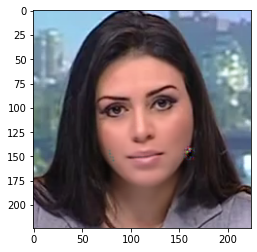

fakemask shape is (224, 224)


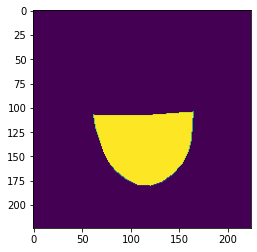

realmask shape is (224, 224)


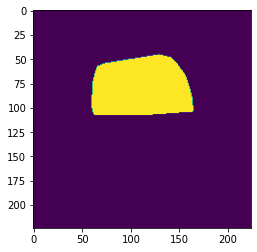

In [3]:
npzfile = np.load('imgs/fakeface.npz')  # load file
keys = [k for k in npzfile]  # ['img', 'fakemask', 'realmask']
print("img shape is {}".format(npzfile["img"].shape))
show_img(npzfile["img"])  # show face imgae
print("fakemask shape is {}".format(npzfile["fakemask"].shape))
show_mask(npzfile["fakemask"])  # show fake mask
print("realmask shape is {}".format(npzfile["realmask"].shape))
show_mask(npzfile["realmask"])  # show real mask

In [4]:
# hyperparameters
PATCH_CLASS = {"bg":0, "real":1, "fake":2}  # classification of the patches
INPUT_IMAGE_SIZE = 224  # the width and height of image
PATCH_SIZE = 16  # the width and height of patch
OMEGA = 3  # magnification of patch pair 

# Patch ground truth and score 

In [5]:
# initialize patch properties
img_patch_gt = [PATCH_CLASS['bg']] * int(INPUT_IMAGE_SIZE / PATCH_SIZE) * int(INPUT_IMAGE_SIZE / PATCH_SIZE)  # the ground truth of each patch, and all patches default to bg
img_patch_score = [1.0] * int(INPUT_IMAGE_SIZE / PATCH_SIZE) * int(INPUT_IMAGE_SIZE / PATCH_SIZE)  # the default score of each patch

In [6]:
from utils import cal_patchgt_score

img_patch_gt, img_patch_score = cal_patchgt_score(npzfile["realmask"], img_patch_gt, img_patch_score, PATCH_CLASS['real'], PATCH_SIZE)  # get real patch and its score
img_patch_gt, img_patch_score = cal_patchgt_score(npzfile["fakemask"], img_patch_gt, img_patch_score, PATCH_CLASS['fake'], PATCH_SIZE)  # get fake patch and its score

print_patchlabel_score(img_patch_gt, 14, 14)
print()
print_patchlabel_score(img_patch_score, 14, 14)

0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  1  1  1  1  1  1  0  0  0  0  
0  0  0  1  1  1  1  1  1  1  0  0  0  0  
0  0  0  1  1  1  1  1  1  1  1  0  0  0  
0  0  0  1  2  2  2  2  2  2  2  0  0  0  
0  0  0  0  2  2  2  2  2  2  2  0  0  0  
0  0  0  0  2  2  2  2  2  2  2  0  0  0  
0  0  0  0  2  2  2  2  2  2  0  0  0  0  
0  0  0  0  0  2  2  2  2  2  0  0  0  0  
0  0  0  0  0  0  2  2  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  
0  0  0  0  0  0  0  0  0  0  0  0  0  0  

1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1.0  1.0  1.0  1.0  1.49  1.26  1.1  1.0  1.01  1.7  1.0  1.0  1.0  1.0  
1.0  1.0  1.0  1.87  1.0  1.0  1.0  1.0  1.0  1.11  1.0  1.0  1.0  1.0  
1.0  1.0  1.0  1.78  1.0  1.0  1.0  1

# Patch pair weights

In [7]:
from utils import get_patch_pair, convert_patchpair_format

patch_pair = get_patch_pair(INPUT_IMAGE_SIZE, PATCH_SIZE)  # create patch pair
patch_pair = convert_patchpair_format(patch_pair)  # convert patch pair format

img_patch_score = np.array(img_patch_score)
patch_pair_weight = img_patch_score[patch_pair[0]] * img_patch_score[patch_pair[1]]
magnification_patch_pair = (patch_pair_weight > 1.001).astype(float) * (OMEGA - 1.0) + 1.0  # magnification of patch pair
patch_pair_weight = patch_pair_weight * magnification_patch_pair

In [8]:
np.savez(
    os.path.join("imgs", "fakeface_output.npz"),
    patch_pair=patch_pair,
    img_patch_gt=np.array(img_patch_gt),
    patch_pair_weight=patch_pair_weight
)